In [50]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from matplotlib.lines import Line2D


from cryptic_rnn import *

In [69]:
def run_exp(trainseqs_old1 , trainseqs_old2 ,testseqs_old1, testseqs_old2, cue_dict,xavier_gain):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    trainseqs = change_dict(trainseqs_old1, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset1 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old2, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset2 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old1, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset1 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old2, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset2 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset1, [trainset1, testset1, testset2], epochs1, hidden_size)
    loss2, acc2 = run_acc(model,optimizer,criterion, trainset2, [trainset2, testset1, testset2], epochs2, hidden_size)

    loss =  np.vstack([loss1, loss2])
    acc = np.vstack([acc1, acc2])
    return {'cue_dict':cue_dict, 'loss':loss, 'acc':acc, 'mod': model, 'test1': testset1, 'test2': testset2}

def run_plot(trainseqs1, trainseqs2, testseqs1, testseqs2, cue_dict, xavier_gain):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs1,trainseqs2, testseqs1,testseqs2, cue_dict, xavier_gain) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list1 = [r['acc'][:,1] for r in res]
    acc_test_list2 = [r['acc'][:,2] for r in res]
    loss_list = [r['loss'] for r in res]
 
    tests1 = [r['test1'] for r in res]
    tests2 = [r['test2'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test1 = np.array([r['acc'][:,1] for r in res]).T
    acc_test2 = np.array([r['acc'][:,2] for r in res]).T
    mods = [r['mod'] for r in res]
    
    _, _, alldfs = predcorr(mods, tests1, hidden_size, plot_corr = True)
    _, _, alldfs = predcorr(mods, tests2, hidden_size, plot_corr = True)
    
    plotNNs([losses], [acc_train, acc_test1, acc_test2], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc1': acc_test1[-1,:], 'test_acc2': acc_test2[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc1 = fully_trained['test_acc1'].mean() 
    fully_trained_test_acc_std1 = fully_trained['test_acc1'].std()
    fully_trained_test_acc2 = fully_trained['test_acc2'].mean() 
    fully_trained_test_acc_std2 = fully_trained['test_acc2'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests1 = [tests1[i] for i in fully_trained_idx]
    ft_tests2 = [tests2[i] for i in fully_trained_idx]
    ft_tests_acc1 = np.array([acc_test_list1[i] for i in fully_trained_idx]).T
    ft_tests_acc2 = np.array([acc_test_list2[i] for i in fully_trained_idx]).T
    ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
    ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])
    
    if len(ft_mods) > 0:
        plt.figure()
        _, dfs1, alldfs = predcorr(ft_mods, ft_tests1, hidden_size, plot_corr = True)
        plt.figure()
        _, dfs2, alldfs = predcorr(ft_mods, ft_tests2, hidden_size, plot_corr = True)
    else:
        r2, dfs, alldfs = 0, 0, 0
    
    plotNNs([ft_loss], [ft_train_acc, ft_tests_acc1, ft_tests_acc2], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
   
    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_test1': acc_test1[-1,:], 'acc_test2': acc_test2[-1,:]})
    
    return {'res':res,'mods':mods ,'dfs1': dfs1, 'dfs2': dfs2,\
            'tests1': tests1, 'tests2': tests2,'cue_dicts': cue_dicts, 'acc_df':acc_df }

def calculate_RDMs_multi_op(res, testseq, fully_trained = True):
    
    acc_df = res['acc_df']
    if fully_trained:
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1)].index
    else:
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 
    
    rdms = [[] for _ in range(5)] # initialise empty lists/arrays
    rdms_p = [[] for _ in range(5)]

    # extracts results from dictionary
    mods = res['mods']
    cue_dicts = res['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(5): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
    return {'rdms': rdms,'ft_cue_dicts': ft_cue_dicts}

def MDS_plot(matlist, trainseqs, train_type = 'p', title = ''):
    
    testseqs = generate_pos_trials('+', all_syms, all_syms, cue_dict) + generate_pos_trials('-', all_syms, all_syms, cue_dict)
    valset = [t for t in testseqs if t not in trainseqs]
    valset_idx = [testseqs.index(val) for val in valset]
    
    signs = ['+']*16 + ['-']*16
    colors2 = ['green', 'blue', 'orange', 'red']*4 + ['green', 'blue', 'orange', 'red']*4
    colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4 + ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A _ _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B _ _'), 
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C _ _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D _ _ '),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ _ A'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ _ B'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ _ C'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ _ D')]
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots(2,2)

    for j, dist in enumerate(matlist[1:]):
        mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
        X_transform = mds.fit_transform(dist)
        ax = axs[math.floor(j/2), j%2]
        ax.title.set_text('step: '+str(j))
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
            ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
            ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)
            ax.annotate(signs[i], (X_transform[i,0], X_transform[i,1]))

    plt.suptitle('2D-MDS'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 


In [191]:
def run_exp(trainseq_list ,testseq_list, cue_dict, xavier_gain, epochs):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    trainset_list = []
    for trainseq in trainseq_list:
        trainseqs = change_dict(trainseq, cue_dict)
        train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
        trainset_list.append(DataLoader(train_inputs, batch_size=batchsize, shuffle=True))
    
    testset_list = []
    for testseq in testseq_list:
        testseqs = change_dict(testseq, cue_dict)
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset_list.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))
        
    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    
    loss = np.empty((0,1))
    acc = np.empty((0,len(testseq_list) + 1))
    
    for i in range(len(trainseq_list)):
        loss1, acc1 = run_acc(model,optimizer,criterion, trainset_list[i], [trainset_list[i]] + testset_list, epochs[i], hidden_size)
        loss =  np.vstack([loss, loss1])
        acc = np.vstack([acc, acc1])
        
    return {'cue_dict':cue_dict, 'loss':loss, 'acc':acc, 'mod': model, 'testset_list': testset_list}

def run_plot(trainseq_list ,testseq_list, cue_dict, xavier_gain, epochs):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseq_list ,testseq_list, cue_dict, xavier_gain, epochs) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list1 = [r['acc'][:,1] for r in res]
    acc_test_list2 = [r['acc'][:,2] for r in res]
    acc_test_list3 = [r['acc'][:,3] for r in res]
    acc_test_list4 = [r['acc'][:,4] for r in res]
    loss_list = [r['loss'] for r in res]
 
    tests1 = [r['testset_list'][0] for r in res]
    tests2 = [r['testset_list'][1] for r in res]
    tests3 = [r['testset_list'][2] for r in res]
    tests4 = [r['testset_list'][3] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test1 = np.array([r['acc'][:,1] for r in res]).T
    acc_test2 = np.array([r['acc'][:,2] for r in res]).T
    acc_test3 = np.array([r['acc'][:,3] for r in res]).T
    acc_test4 = np.array([r['acc'][:,4] for r in res]).T
    mods = [r['mod'] for r in res]
    
    plotNNs([losses], [acc_train, acc_test1, acc_test2, acc_test3, acc_test4], \
            ['train', 'test1', 'test2', 'test3', 'test4'], colors = ['green', 'orange', 'red', 'aqua', 'purple'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:]})
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    
    ft_tests1 = [tests1[i] for i in fully_trained_idx]
    ft_tests2 = [tests2[i] for i in fully_trained_idx]
    ft_tests3 = [tests3[i] for i in fully_trained_idx]
    ft_tests4 = [tests4[i] for i in fully_trained_idx]

    ft_tests_acc1 = np.array([acc_test_list1[i] for i in fully_trained_idx]).T
    ft_tests_acc2 = np.array([acc_test_list2[i] for i in fully_trained_idx]).T
    ft_tests_acc3 = np.array([acc_test_list3[i] for i in fully_trained_idx]).T
    ft_tests_acc4 = np.array([acc_test_list4[i] for i in fully_trained_idx]).T

    ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
    ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])
    
    if len(ft_mods) > 0:
        plt.figure()
        _, dfs1, alldfs = predcorr(ft_mods, ft_tests1, hidden_size, plot_corr = True)
        plt.figure()
        _, dfs2, alldfs = predcorr(ft_mods, ft_tests2, hidden_size, plot_corr = True)
        plt.figure()
        _, dfs3, alldfs = predcorr(ft_mods, ft_tests3, hidden_size, plot_corr = True)
        plt.figure()
        _, dfs4, alldfs = predcorr(ft_mods, ft_tests4, hidden_size, plot_corr = True)
    
        plotNNs([ft_loss], [ft_train_acc, ft_tests_acc1, ft_tests_acc2, ft_tests_acc3, ft_tests_acc4], \
            ['train', 'pos_add', 'neg_sub', 'pos_sub', 'neg_add'], colors = ['green', 'orange', 'red', 'purple', 'aqua'], title = '', shift = 0)
        
        acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_test1': acc_test1[-1,:], 'acc_test2': acc_test2[-1,:],
                           'acc_test3': acc_test3[-1,:], 'acc_test4': acc_test4[-1,:]})
    else:
        acc_df = 0
        
    return {'res':res,'mods':mods ,'cue_dicts': cue_dicts, 'acc_df':acc_df,\
            'dfs1': dfs1,'dfs2': dfs2,'dfs3': dfs3,'dfs4': dfs4  }

def calculate_RDMs_multi_op(res, testseq, fully_trained = True):
    
    acc_df = res['acc_df']
    if fully_trained:
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1)].index
    else:
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 
    
    rdms = [[] for _ in range(5)] # initialise empty lists/arrays
    rdms_p = [[] for _ in range(5)]

    # extracts results from dictionary
    mods = res['mods']
    cue_dicts = res['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(5): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
    return {'rdms': rdms,'ft_cue_dicts': ft_cue_dicts}

def MDS_plot(matlist, trainseqs, train_type = 'p', title = ''):
    
    testseqs = generate_pos_trials('+', all_syms, all_syms, cue_dict) + generate_neg_trials('-', all_syms, all_syms, cue_dict)
    valset = [t for t in testseqs if t not in trainseqs]
    valset_idx = [testseqs.index(val) for val in valset]
    
    signs = ['+']*16 + ['-']*16
    colors2 = ['green', 'blue', 'orange', 'red']*4 + ['green', 'blue', 'orange', 'red']*4
    colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4 + ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A _ _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B _ _'), 
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C _ _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D _ _ '),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ _ A'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ _ B'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ _ C'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ _ D')]
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots(2,2)

    for j, dist in enumerate(matlist[1:]):
        mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
        X_transform = mds.fit_transform(dist)
        ax = axs[math.floor(j/2), j%2]
        ax.title.set_text('step: '+str(j+1))
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
            ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
            ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)
            ax.annotate(signs[i], (X_transform[i,0], X_transform[i,1]))

    plt.suptitle('2D-MDS'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 

    
# def MDS_plot(matlist, trainseqs, train_type = 'p', title = ''):
    
#     testseqs = testseq_list
#     valset = [t for t in testseqs if t not in trainseqs]
#     valset_idx = [testseqs.index(val) for val in valset]
    
#     signs = ['++']*16 + ['--']*16 + ['+-']*16 + ['-+']*16
#     colors2 = ['green', 'blue', 'orange', 'red']*16
#     colors1 = (['green']*4 + ['blue']*4 + ['orange']*4)*4
#     legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A _ '),
#                        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B _ '), 
#                        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C _ '),
#                        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D _  '),
#                        Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label='  _ A'),
#                        Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label='  _ B'), 
#                        Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label='  _ C'),
#                        Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label='  _ D')]
    
#     plt.rcParams['figure.figsize'] = 6, 6
#     fig, axs = plt.subplots(2,2)

#     for j, dist in enumerate(matlist[1:]):
#         mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
#         X_transform = mds.fit_transform(dist)
#         ax = axs[math.floor(j/2), j%2]
#         ax.title.set_text('step: '+str(j+1))
#         for i in range(len(testseqs)):
#             if i in valset_idx:
#                 alph = 1
#             else:
#                 alph = 0.2
#             ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
#             ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)
#             ax.annotate(signs[i], (X_transform[i,0], X_transform[i,1]))

#     plt.suptitle('2D-MDS'+title)
#     fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 


In [6]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 12
num_sims = 8

# 
xavier_gain = 0.0001

In [7]:
add = '+'
sub = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
print(primitives)
neg_primitives = generate_neg_primitives(all_syms, cue_dict)
print(neg_primitives)
pos_primitives = generate_pos_primitives(all_syms, cue_dict)
print(pos_primitives)

{'A': 7, 'B': 17, 'C': 11, 'D': 3}
[['A', '=', 7], ['B', '=', 17], ['C', '=', 11], ['D', '=', 3]]
[[('-', 'A'), '=', -7], [('-', 'B'), '=', -17], [('-', 'C'), '=', -11], [('-', 'D'), '=', -3]]
[[('+', 'A'), '=', 7], [('+', 'B'), '=', 17], [('+', 'C'), '=', 11], [('+', 'D'), '=', 3]]


In [159]:
# sequences

trainseqs_pos_add = generate_pos_other(add, all_syms, cue_dict)
trainseqs_neg_sub = generate_neg_other(sub, all_syms, cue_dict)
trainseqs_neg_add = generate_neg_other(add, all_syms, cue_dict)
trainseqs_pos_sub = generate_pos_other(sub, all_syms, cue_dict)

testseqs_pos_add = generate_pos_trials(add, all_syms, all_syms, cue_dict)
testseqs_pos_add = [seq for seq in testseqs_pos_add  if seq not in trainseqs_pos_add]
testseqs_neg_sub = generate_neg_trials(sub, all_syms, all_syms, cue_dict)
testseqs_neg_sub = [seq for seq in testseqs_neg_sub  if seq not in trainseqs_neg_sub]
testseqs_neg_add = generate_neg_trials(add, all_syms, all_syms, cue_dict)
testseqs_neg_add = [seq for seq in testseqs_neg_add  if seq not in trainseqs_neg_add]
testseqs_pos_sub = generate_pos_trials(sub, all_syms, all_syms, cue_dict)
testseqs_pos_sub = [seq for seq in testseqs_pos_sub  if seq not in trainseqs_pos_sub]

testseq_list = [testseqs_pos_add, testseqs_neg_sub, testseqs_pos_sub, testseqs_neg_add]

print(testseqs_neg_sub[:10])

[[('-', 'A'), ('-', 'A'), '=', -14], [('-', 'A'), ('-', 'C'), '=', -18], [('-', 'A'), ('-', 'D'), '=', -10], [('-', 'B'), ('-', 'A'), '=', -24], [('-', 'B'), ('-', 'B'), '=', -34], [('-', 'B'), ('-', 'D'), '=', -20], [('-', 'C'), ('-', 'A'), '=', -18], [('-', 'C'), ('-', 'B'), '=', -28], [('-', 'C'), ('-', 'C'), '=', -22], [('-', 'D'), ('-', 'B'), '=', -20]]


# Run RNNs

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 24], [('+', 'B'), ('+', 'C'), '=', 28], [('+', 'C'), ('+', 'D'), '=', 14], [('+', 'D'), ('+', 'A'), '=', 10], [('+', 'A'), '=', 7], [('+', 'B'), '=', 17], [('+', 'C'), '=', 11], [('+', 'D'), '=', 3]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 14], [('+', 'A'), ('+', 'C'), '=', 18], [('+', 'A'), ('+', 'D'), '=', 10], [('+', 'B'), ('+', 'A'), '=', 24], [('+', 'B'), ('+', 'B'), '=', 34], [('+', 'B'), ('+', 'D'), '=', 20], [('+', 'C'), ('+', 'A'), '=', 18], [('+', 'C'), ('+', 'B'), '=', 28], [('+', 'C'), ('+', 'C'), '=', 22], [('+', 'D'), ('+', 'B'), '=', 20], [('+', 'D'), ('+', 'C'), '=', 14], [('+', 'D'), ('+', 'D'), '=', 6]]
run time:  8.77391041914622
7


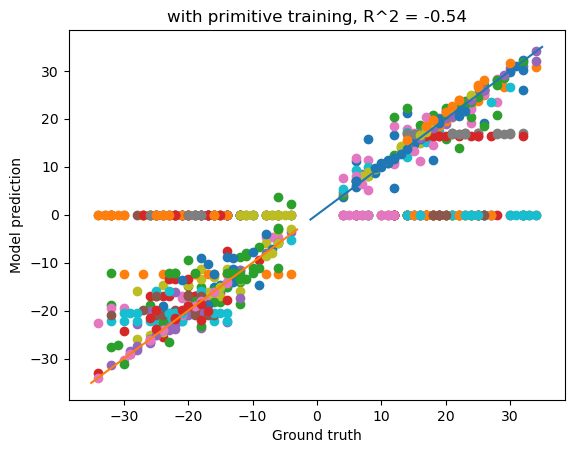

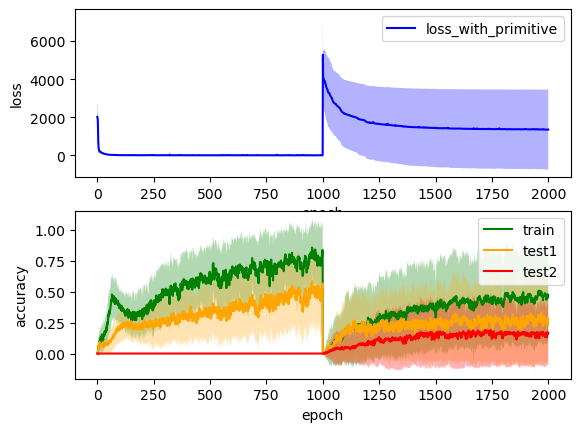

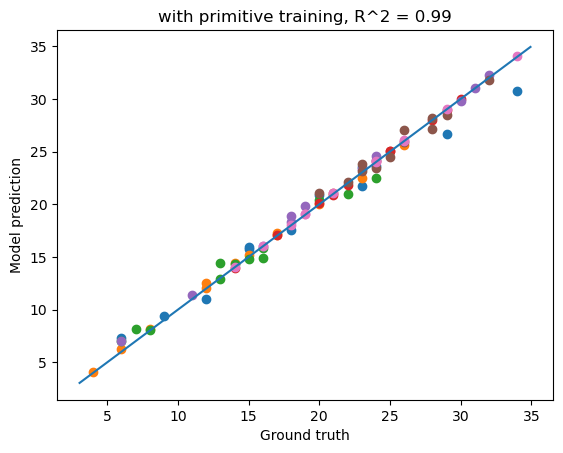

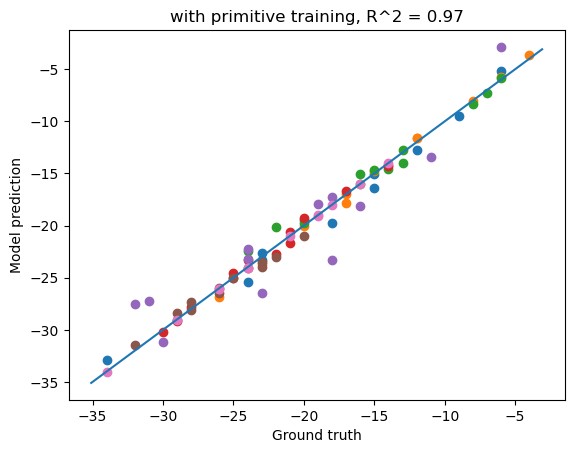

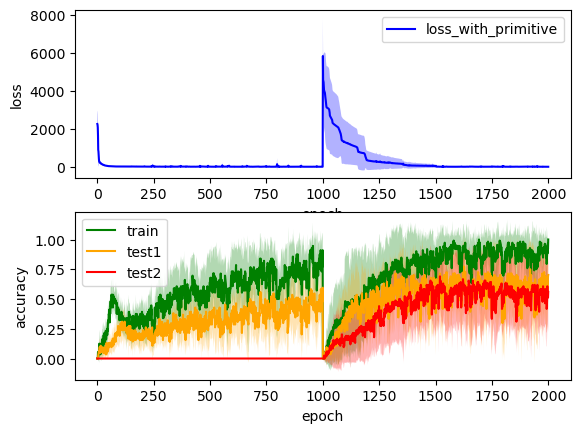

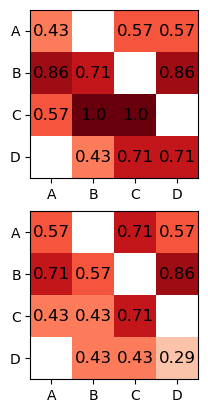

In [10]:
# without basic primitives -------- skip
epochs1 = 1000
epochs2 = 1000

num_sims = 32

xavier_gain = 0.0001

trainseqs1 = generate_pos_other(add, all_syms, cue_dict)+ pos_primitives
trainseqs2 = generate_neg_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1
testseqs_add = generate_pos_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_neg_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add  if seq not in trainseqs1]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs2]

print('trainseqs ', trainseqs1)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs1, trainseqs2, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])

run time:  30.844772148132325
63


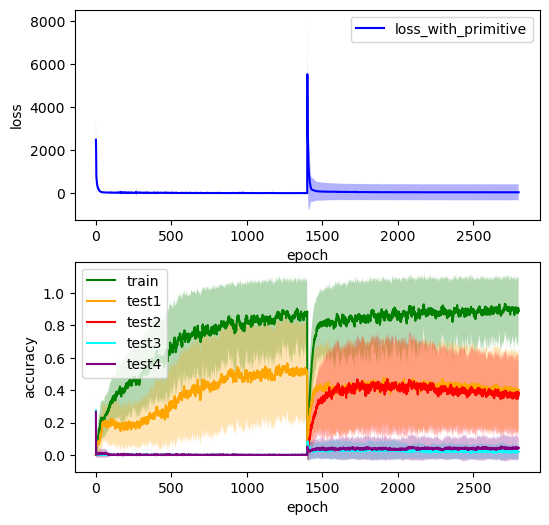

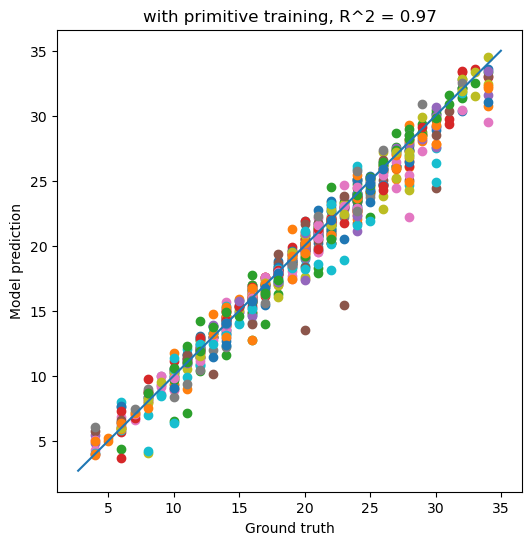

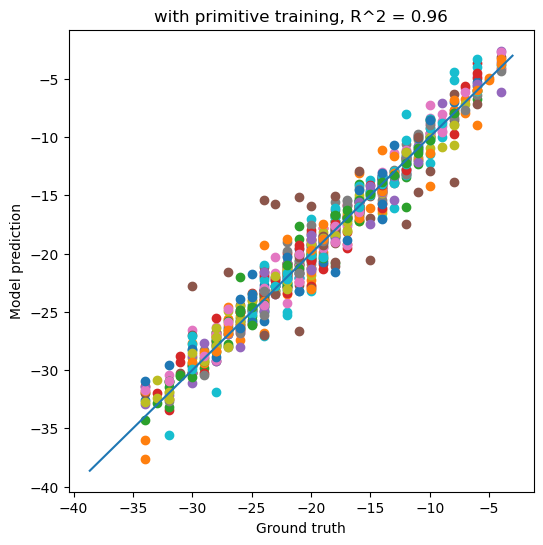

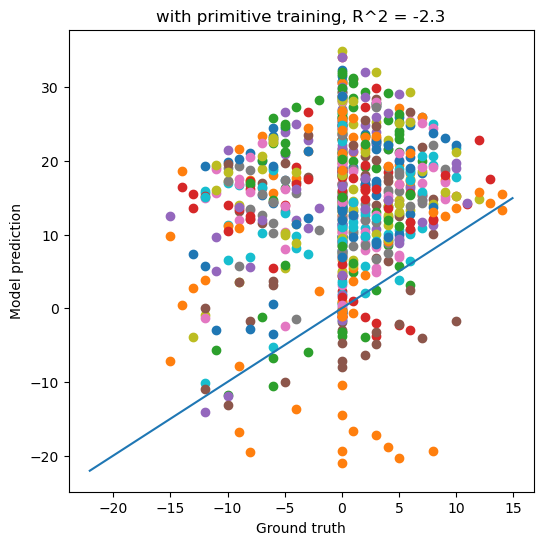

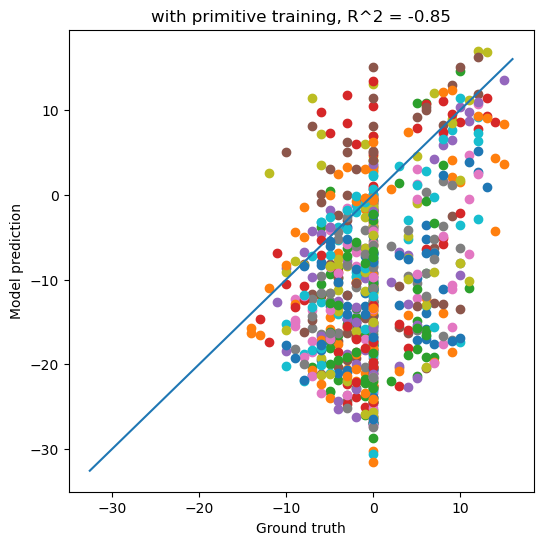

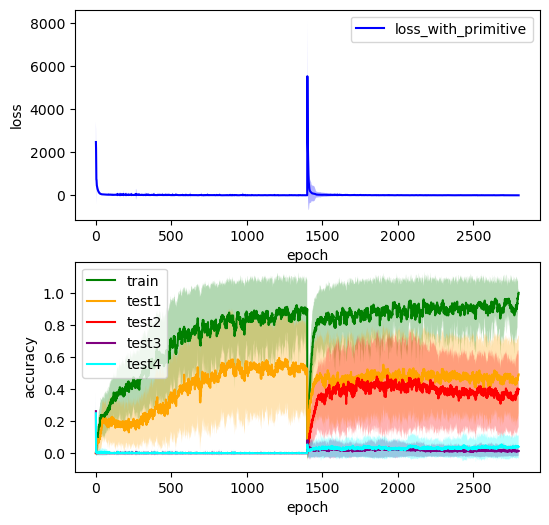

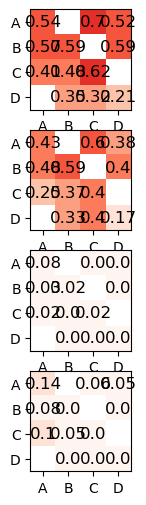

In [164]:
# with basic primitives 2 stage **************
epochs = 1400

num_sims = 104

xavier_gain = 0.0001

trainseqs1 = generate_pos_other(add, all_syms, cue_dict)+ pos_primitives + primitives
trainseqs2 = generate_neg_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1

res1 = run_plot([trainseqs1, trainseqs2], testseq_list, cue_dict, xavier_gain)

fig, ax = plt.subplots(4,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])
heatmap_acc_sign(num_inputs, res1['dfs3'], ax[2])
heatmap_acc_sign(num_inputs, res1['dfs4'], ax[3])

In [186]:
primitives

[['A', '=', 7], ['B', '=', 17], ['C', '=', 11], ['D', '=', 3]]

run time:  7.513556631406148
2


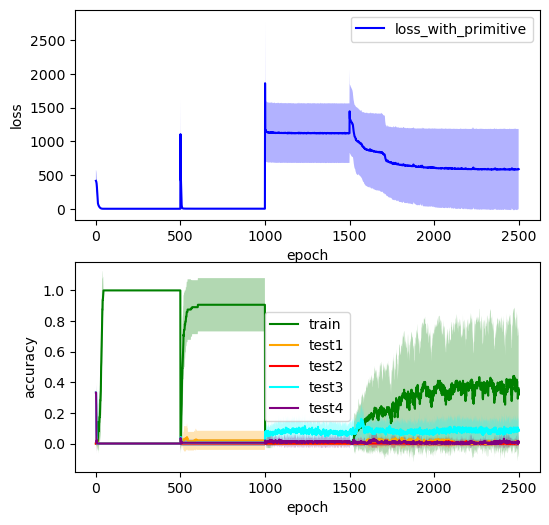

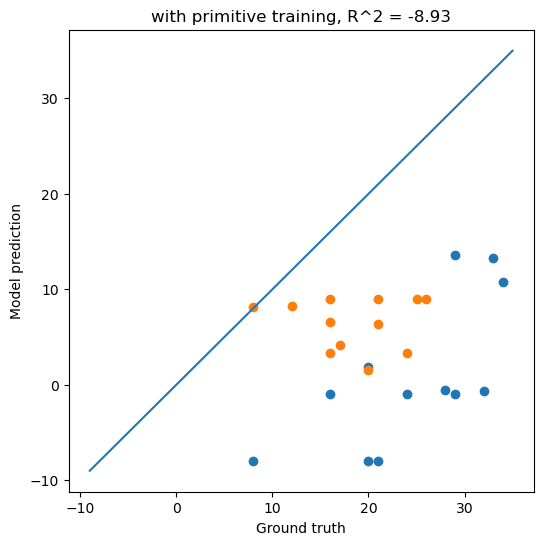

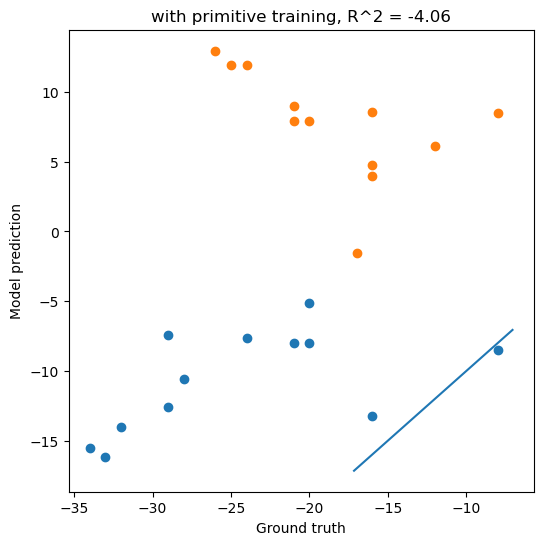

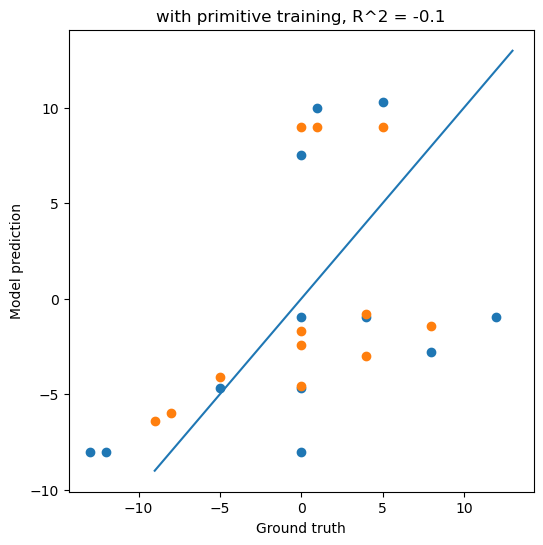

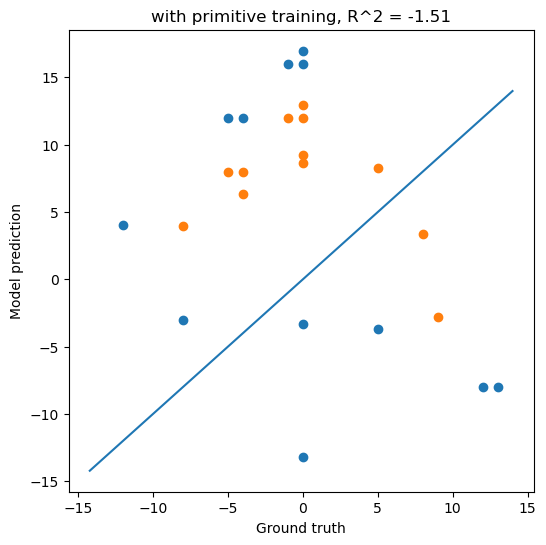

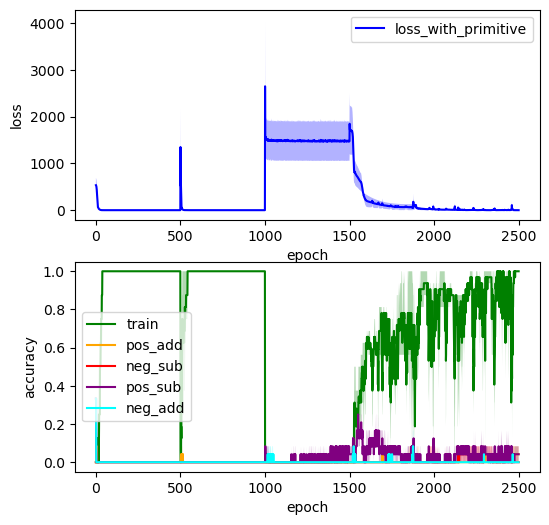

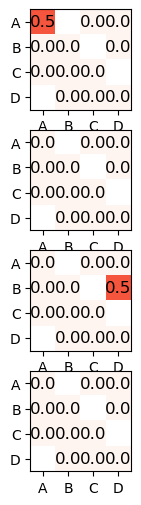

In [189]:
# with basic primitives 3 stage **************

epochs = [500,500, 500, 1000]

num_sims = 16
hidden_soze=20
xavier_gain = 0.0001

trainseqs_prim1 = primitives
trainseqs_prim2 = pos_primitives + primitives
trainseqs_prim3 = pos_primitives + primitives + neg_primitives
trainseqs1 = generate_pos_other(sub, all_syms, cue_dict)+ trainseqs_prim3
# trainseqs2 = generate_neg_other(sub, all_syms, cue_dict) + trainseqs1
# trainseqs3 = generate_pos_other(sub, all_syms, cue_dict)+ trainseqs2

res2 = run_plot([trainseqs_prim1,trainseqs_prim2,trainseqs_prim3, trainseqs1], testseq_list, cue_dict, xavier_gain, epochs)

fig, ax = plt.subplots(4,1)
heatmap_acc_sign(num_inputs, res2['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res2['dfs2'], ax[1])
heatmap_acc_sign(num_inputs, res2['dfs3'], ax[2])
heatmap_acc_sign(num_inputs, res2['dfs4'], ax[3])

run time:  3.3218112627665204
0


ValueError: need at least one array to concatenate

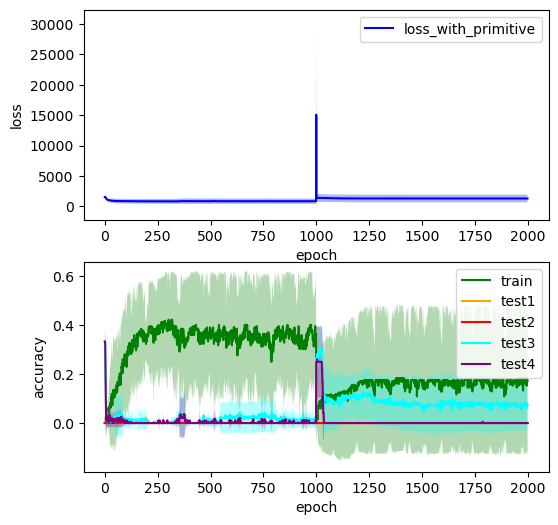

In [190]:
# with basic primitives 3 stage **************

epochs = [1000, 1000]

num_sims = 16
hidden_soze=20
xavier_gain = 0.0001

trainseqs_prim =  pos_primitives + primitives + neg_primitives
trainseqs1 = generate_pos_other(sub, all_syms, cue_dict)+ trainseqs_prim3
# trainseqs2 = generate_neg_other(sub, all_syms, cue_dict) + trainseqs1
# trainseqs3 = generate_pos_other(sub, all_syms, cue_dict)+ trainseqs2

res22 = run_plot([trainseqs_prim, trainseqs1], testseq_list, cue_dict, xavier_gain, epochs)

fig, ax = plt.subplots(4,1)
heatmap_acc_sign(num_inputs, res2['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res2['dfs2'], ax[1])
heatmap_acc_sign(num_inputs, res2['dfs3'], ax[2])
heatmap_acc_sign(num_inputs, res2['dfs4'], ax[3])

In [ ]:
# with basic primitives 4 stage **************

epochs = 2000

num_sims = 104

xavier_gain = 0.0001

trainseqs1 = generate_pos_other(add, all_syms, cue_dict)+ pos_primitives + primitives
trainseqs2 = generate_neg_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1
trainseqs3 = generate_pos_other(sub, all_syms, cue_dict)+ trainseqs2
trainseqs4 = generate_neg_other(add, all_syms, cue_dict)+ trainseqs2

res3 = run_plot([trainseqs1, trainseqs2, trainseqs3, trainseqs4], testseq_list, cue_dict, xavier_gain)

fig, ax = plt.subplots(4,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])
heatmap_acc_sign(num_inputs, res1['dfs3'], ax[2])
heatmap_acc_sign(num_inputs, res1['dfs4'], ax[3])

In [170]:
hidden_size


30

In [ ]:
def calculate_RDMs(res, testseq, fully_trained = True):
    
    acc_df = res['acc_df']
    if fully_trained:
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    else:
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 
    
    rdms = [[] for _ in range(5)] # initialise empty lists/arrays
    rdms_p = [[] for _ in range(5)]

    # extracts results from dictionary
    mods = res['mods']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(5): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(5):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}


run time:  13.298734184106191
3


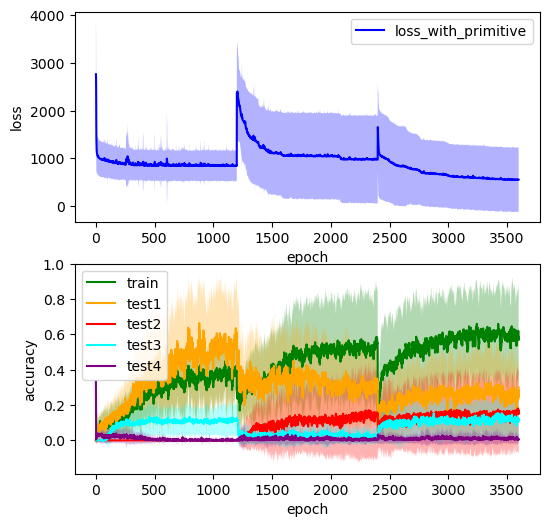

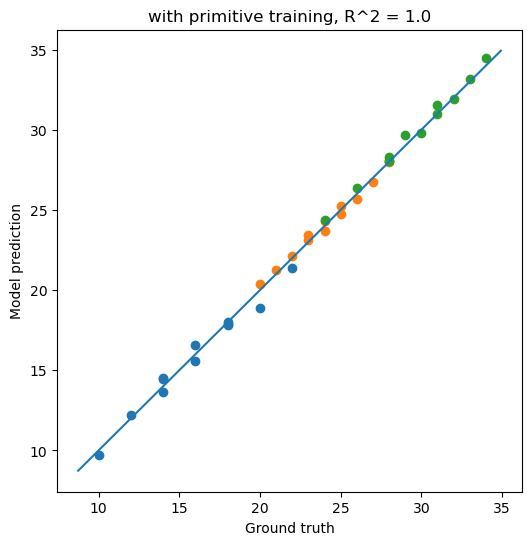

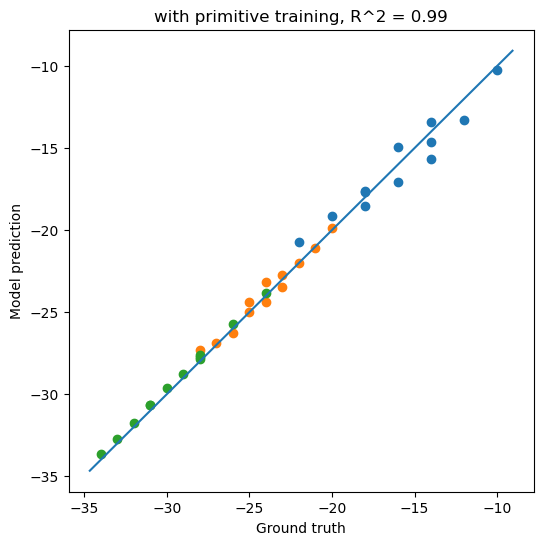

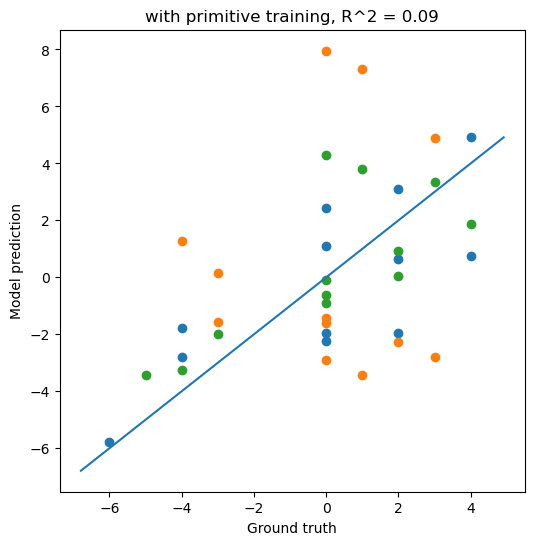

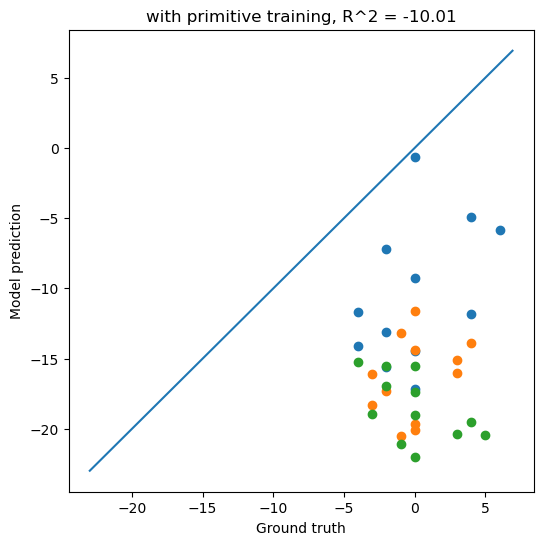

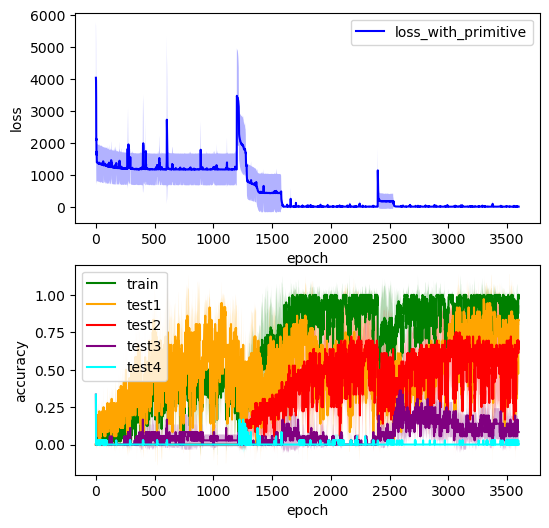

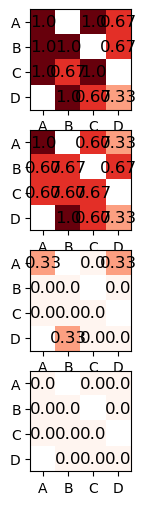

In [156]:
epochs = 1200

num_sims = 32

xavier_gain = 0.0001

trainseqs1 = trainseqs_pos_add + pos_primitives + primitives + neg_primitives
trainseqs2 = trainseqs1 + trainseqs_neg_sub
trainseqs3 = trainseqs2 + trainseqs_pos_sub

trainseq_list = [trainseqs1, trainseqs2, trainseqs3]
testseq_list = [testseqs_pos_add, testseqs_neg_sub, testseqs_pos_sub, testseqs_neg_add]

res1 = run_plot(trainseq_list, testseq_list, cue_dict, xavier_gain)

fig, ax = plt.subplots(4,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])
heatmap_acc_sign(num_inputs, res1['dfs3'], ax[2])
heatmap_acc_sign(num_inputs, res1['dfs4'], ax[3])

run time:  21.394446905454
7


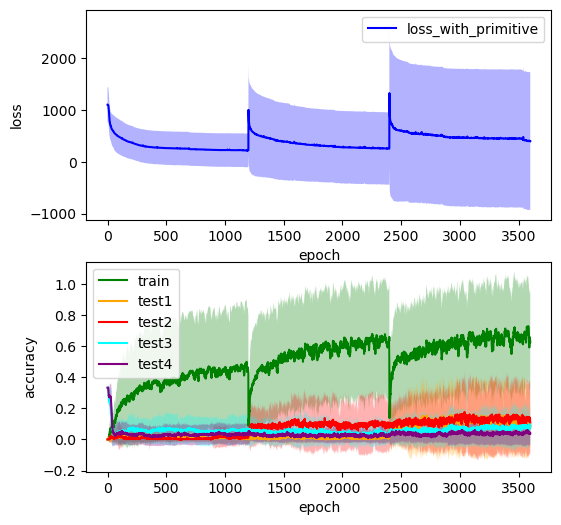

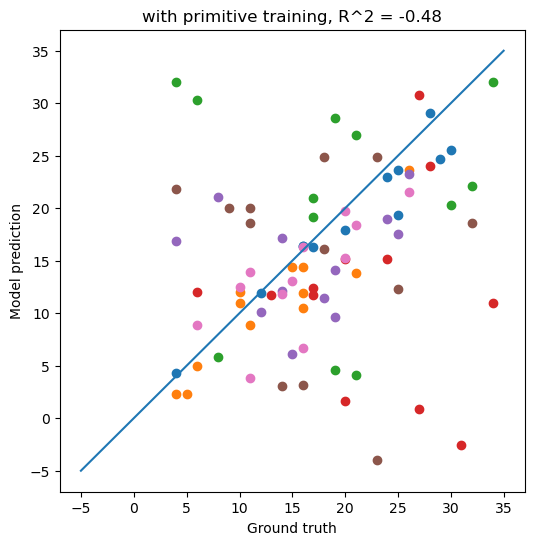

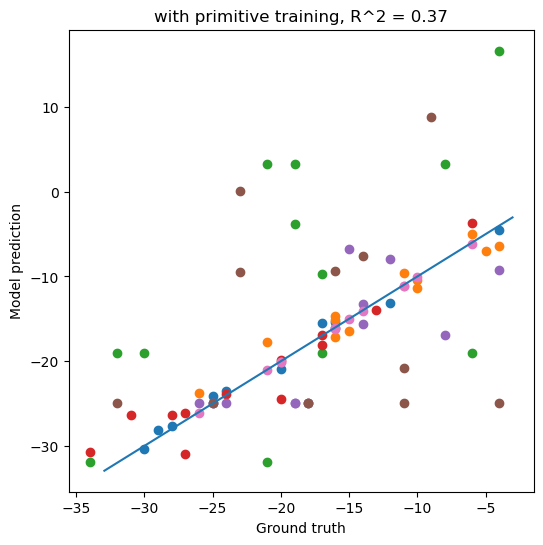

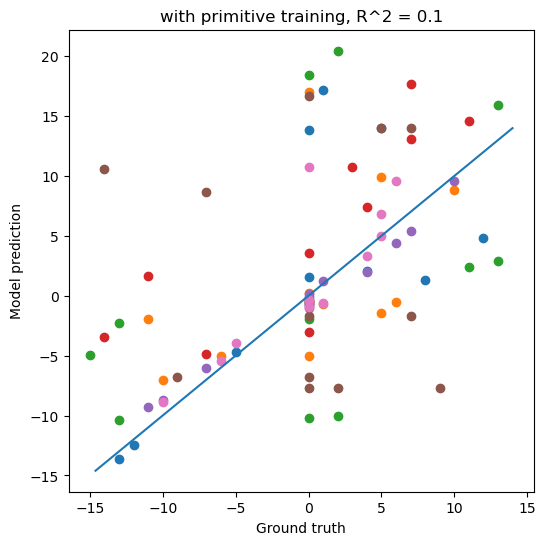

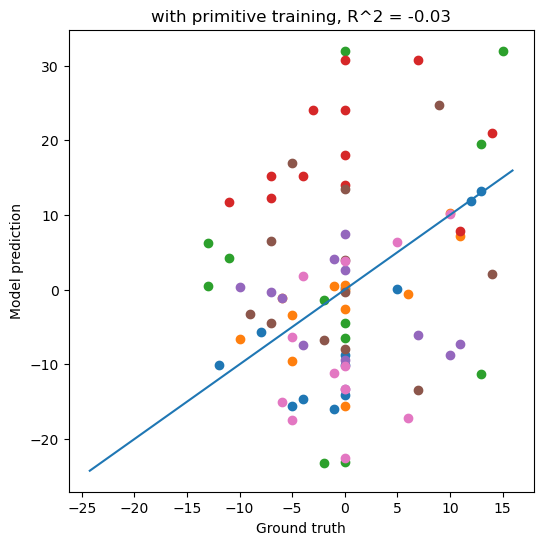

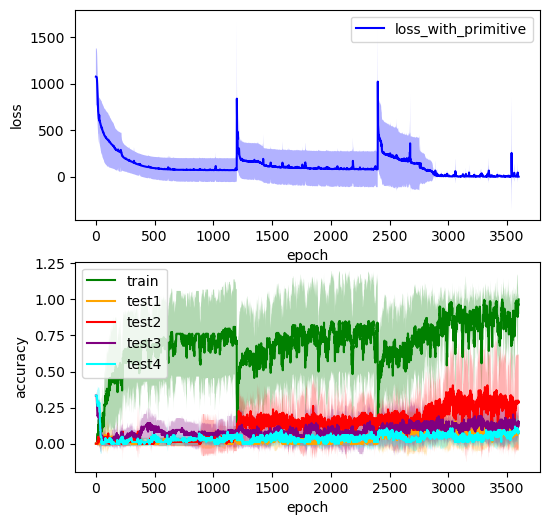

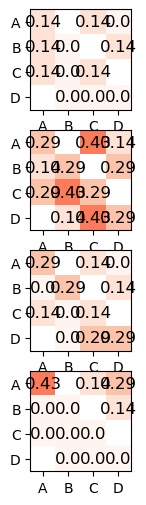

In [157]:
epochs = 1200

num_sims = 32
hidden_size=30
xavier_gain = 0.0001

trainseqs1 = trainseqs_pos_sub + pos_primitives + neg_primitives
trainseqs2 = trainseqs1 + trainseqs_neg_sub
trainseqs3 = trainseqs2 + trainseqs_pos_add

trainseq_list = [trainseqs1, trainseqs2, trainseqs3]
testseq_list = [testseqs_pos_add, testseqs_neg_sub, testseqs_pos_sub, testseqs_neg_add]

res1 = run_plot(trainseq_list, testseq_list, cue_dict, xavier_gain)

fig, ax = plt.subplots(4,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])
heatmap_acc_sign(num_inputs, res1['dfs3'], ax[2])
heatmap_acc_sign(num_inputs, res1['dfs4'], ax[3])

KeyError: 'dfs3'

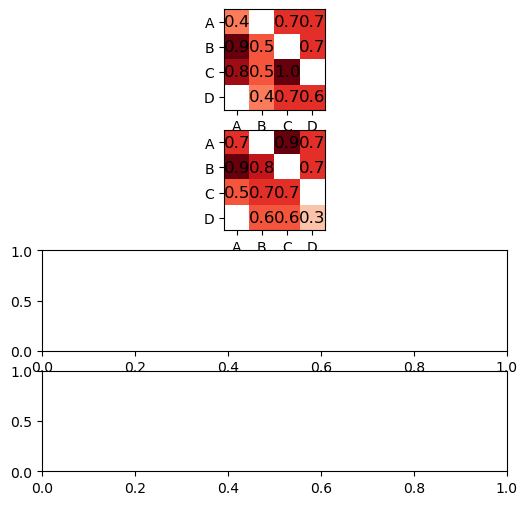

In [138]:
fig, ax = plt.subplots(4,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])
heatmap_acc_sign(num_inputs, res1['dfs3'], ax[2])
heatmap_acc_sign(num_inputs, res1['dfs4'], ax[3])

In [149]:
res1.keys()

dict_keys(['res', 'mods', 'dfs1', 'dfs2', 'tests1', 'tests2', 'cue_dicts', 'acc_df'])

run time:  9.349482484658559
12


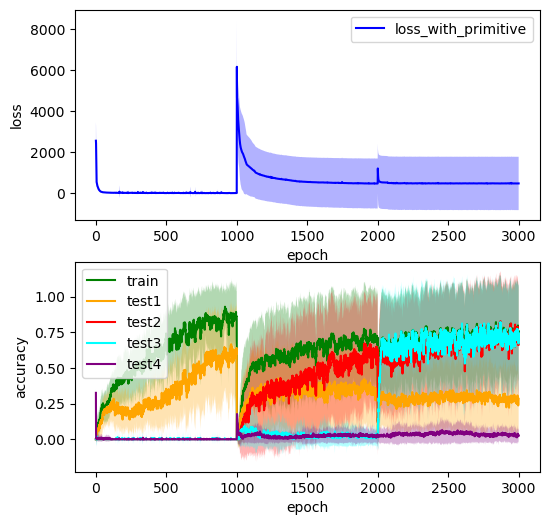

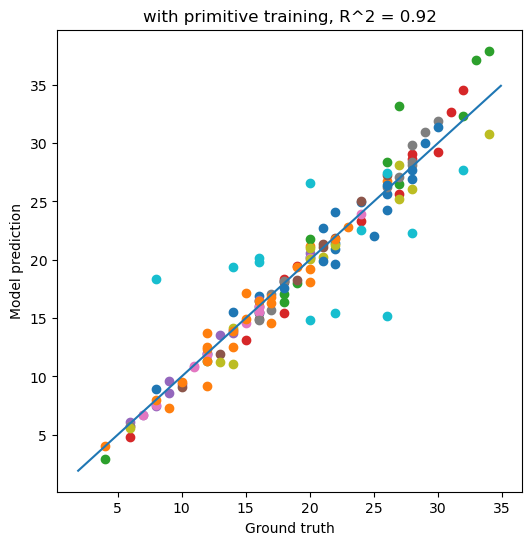

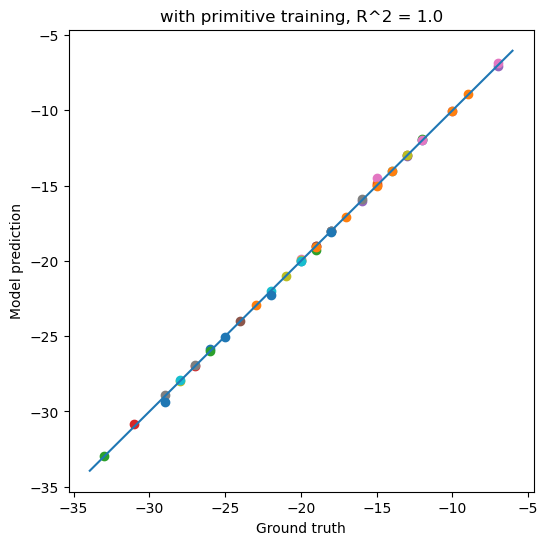

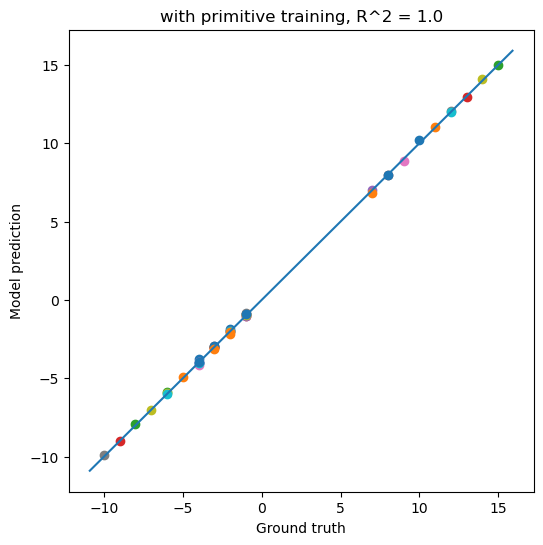

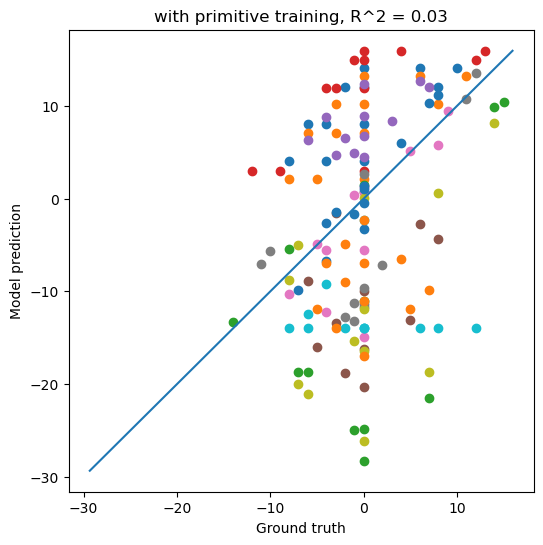

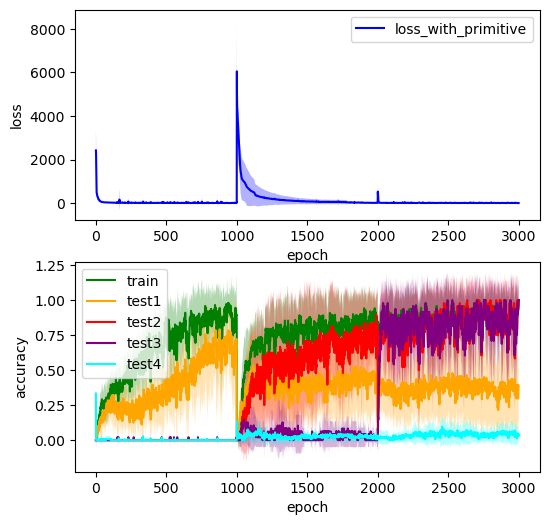

In [137]:
epochs = 1000
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseq_list ,testseq_list, cue_dict, xavier_gain) for i in range(num_sims))
t2 = time.time()
print('run time: ', (t2-t1)/60)

acc_train_list = [r['acc'][:,0] for r in res]
acc_test_list1 = [r['acc'][:,1] for r in res]
acc_test_list2 = [r['acc'][:,2] for r in res]
acc_test_list3 = [r['acc'][:,3] for r in res]
acc_test_list4 = [r['acc'][:,4] for r in res]
loss_list = [r['loss'] for r in res]

tests1 = [r['testset_list'][0] for r in res]
tests2 = [r['testset_list'][1] for r in res]
tests3 = [r['testset_list'][2] for r in res]
tests4 = [r['testset_list'][3] for r in res]
cue_dicts = [r['cue_dict'] for r in res]
losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
acc_test3 = np.array([r['acc'][:,3] for r in res]).T
acc_test4 = np.array([r['acc'][:,4] for r in res]).T
mods = [r['mod'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2, acc_test3, acc_test4], \
        ['train', 'test1', 'test2', 'test3', 'test4'], colors = ['green', 'orange', 'red', 'aqua', 'purple'], title = '', shift = 0)

final_accs = pd.DataFrame({'train_acc': acc_train[-1,:]})
fully_trained = final_accs[final_accs['train_acc'] == 1]
fully_trained_idx = fully_trained.index    
ft_mods = [mods[i] for i in fully_trained_idx]
print(len(ft_mods))

ft_tests1 = [tests1[i] for i in fully_trained_idx]
ft_tests2 = [tests2[i] for i in fully_trained_idx]
ft_tests3 = [tests3[i] for i in fully_trained_idx]
ft_tests4 = [tests4[i] for i in fully_trained_idx]

ft_tests_acc1 = np.array([acc_test_list1[i] for i in fully_trained_idx]).T
ft_tests_acc2 = np.array([acc_test_list2[i] for i in fully_trained_idx]).T
ft_tests_acc3 = np.array([acc_test_list3[i] for i in fully_trained_idx]).T
ft_tests_acc4 = np.array([acc_test_list4[i] for i in fully_trained_idx]).T

ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])

if len(ft_mods) > 0:
    plt.figure()
    _, dfs1, alldfs = predcorr(ft_mods, ft_tests1, hidden_size, plot_corr = True)
    plt.figure()
    _, dfs2, alldfs = predcorr(ft_mods, ft_tests2, hidden_size, plot_corr = True)
    plt.figure()
    _, dfs3, alldfs = predcorr(ft_mods, ft_tests3, hidden_size, plot_corr = True)
    plt.figure()
    _, dfs4, alldfs = predcorr(ft_mods, ft_tests4, hidden_size, plot_corr = True)

    plotNNs([ft_loss], [ft_train_acc, ft_tests_acc1, ft_tests_acc2, ft_tests_acc3, ft_tests_acc4], \
        ['train', 'test1', 'test2', 'test3', 'test4'], colors = ['green', 'orange', 'red', 'purple', 'aqua'], title = '', shift = 0)


no. 100% trained RNNs:  63


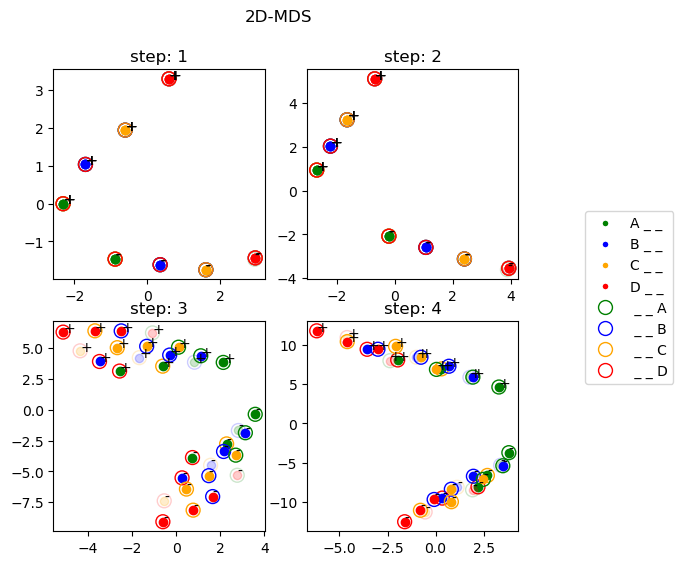

In [192]:
testseqs = generate_pos_trials(add, all_syms, all_syms, cue_dict) + generate_neg_trials(sub, all_syms, all_syms, cue_dict)
trainseqs = generate_pos_other(add, all_syms, cue_dict) + generate_neg_other(sub, all_syms, cue_dict)

res_rdm = calculate_RDMs_multi_op(res1, testseqs)

rdms = res_rdm['rdms']
cue_dicts = res_rdm['ft_cue_dicts']
matlist = [np.array(rdms[t]).mean(axis=0) for t in range(5)]

MDS_plot(matlist, trainseqs, title = '')

In [178]:
from sklearn.decomposition import PCA
for i in range(1,len(matlist)):
    pca = PCA(n_components=3)
    pca_np = pca.fit(matlist[i])
    print('no prims: step',i,'  ', pca.explained_variance_ratio_)
                       

no prims: step 1    [0.64297151 0.25696084 0.0450457 ]
no prims: step 2    [0.85061401 0.10931549 0.02447088]
no prims: step 3    [0.89034595 0.08257116 0.01037038]
no prims: step 4    [0.93950176 0.046522   0.00775876]
